In [175]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import pymoc
import glob
from time import sleep
import os
from astropy.nddata.utils import Cutout2D
import herschelhelp.cutouts_server as ctts

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp import image_plotting
import pyvo as vo
import glob

import copy

In [2]:
def read_fits(filename):
    hdulist = fits.open(filename)
    data = hdulist[1].data
    hdulist.close()
    return(data)

In [3]:
def find_posteror_source(source_num,source_id):
    #finds the pkl file corresponding to the source you give.
    # Source_num: the row number of the source you want the pkl file for
    # Source_id: the sources id
    
    if type(source_num)==int:
        source_num = [source_num]
        source_id = [source_id]
    

    source_list = []
    for n,num in enumerate(source_num):
        file_num = int(num/10)
        #print(file_num)
        #print('data/fir_v2/xidplus_run_{}/lofar_xidplus_fir_{}_rerun.pkl.pkl'.format(file_num,file_num))
        name = file_list[file_num].replace('fits','pkl.pkl')
        #print(name)
        priors,posterior = xidplus.load(name)
        #print(source_id[n])
        if source_id[n] not in priors[0].ID:
            print('source number :{}: not in opened file. Something is wrong'.format(num))
        source_list.append([priors,posterior])
        
    return(source_list)

In [199]:
lofar_orig = Table.read('data/data_release/final_cross_match_catalogue-v0.1.fits')
mips_prior = Table.read('data/data_release/xidplus_prior_cat_MIPS.fits')
pacs_prior = Table.read('data/data_release/xidplus_prior_cat.fits')

In [203]:
lofar_orig[0]

Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,FLAG_WORKFLOW,Prefilter,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,FLAG_OVERLAP,Separation,help_id,RA_HELP,DEC_HELP,EBV,Z_SPEC,CLASS_STAR,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,AGN,optAGN,IRAGN,XrayAGN,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,hp_idx_11,hp_depth_cluster
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,bytes27,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bool,bool,bool,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,bytes6,int64,int32
ILTJ155957.58+550052.4,239.98990167026162,55.01456045936245,5.366954914924915e-05,8.08706707123675e-05,0.0003958345213565919,5.4160526835678236e-05,0.0003247963953282784,2.715224507873135e-05,S,0.002071920400992901,0.0016345290335764496,166.30848152559156,0.00019279093100176814,0.00012276320016402095,13.835288085283342,0.0,0.0,0.0,1,0,329.1186755105229,239.98983453474398,55.01474018731156,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,Create initial sources,LR,,7,1,1018637,73464.984,38011.69,239.98983453474398,55.01474018731156,1,1180605,--,7

## Processing MIPS output

In [135]:
file_list = glob.glob('data/fir_MIPS/*/lofar_xidplus*.fits')
num_not = np.arange(428,860,1)

lofar_mips_table = Table.read(file_list[0])
for i,filename in enumerate(file_list[1:]):
    #print(filename)
    if i%50==0:
        print(i)
    
    run_num = 0
    try:
        run_num = int(filename[24:27])
    except:
        run_num = 0
    #print(run_num)
    if run_num>428:
        continue
    
    #print(filename)
    new_table = Table.read(filename,memmap=False)
    if len(new_table)!=100:
        print(filename)
        print('length of table is: {}'.format(len(new_table)))
    lofar_mips_table = vstack([lofar_mips_table,new_table])
data_rerun_table = lofar_mips_table

0
data/fir_MIPS/xidplus_run_77/lofar_xidplus_fir_77_rerun.fits
length of table is: 36
50


In [136]:
lofar_mips_table[0]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32
ILTJ160722.27+561423.0,241.84285734565037,56.239724313799,104.34947,163.0999,35.189613,8.9036875,4.9586943e-06,0.99995404,3924.2373,0.0


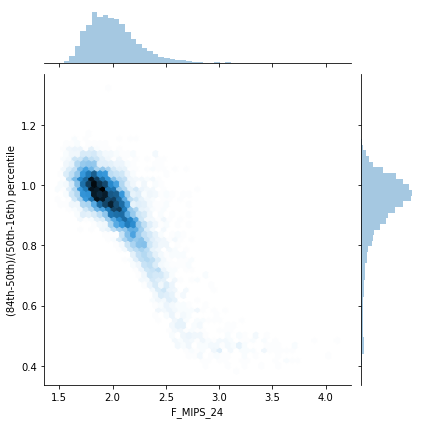

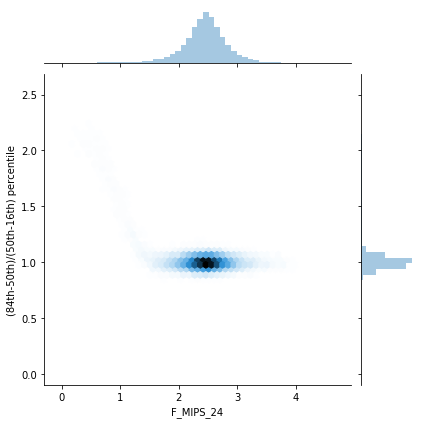

In [137]:
skew=(lofar_mips_table['FErr_MIPS_24_u']-lofar_mips_table['F_MIPS_24'])/(lofar_mips_table['F_MIPS_24']-lofar_mips_table['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_mips_table['F_MIPS_24']),y=skew, kind='hex')

skew=(lofar_cat['FErr_MIPS_24_u']-lofar_cat['F_MIPS_24'])/(lofar_cat['F_MIPS_24']-lofar_cat['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_cat['F_MIPS_24']),y=skew, kind='hex')

In [138]:
lofar_mips_table.add_column(Column(np.zeros(len(data_rerun_table), dtype=bool),name='flag_mips_24'))



In [139]:
ind_SERVS_250=(lofar_mips_table['Pval_res_24']>0.5) | (lofar_mips_table['F_MIPS_24'] > 10**2)
print(ind_SERVS_250.sum(),len(lofar_mips_table))

lofar_mips_table['flag_mips_24'][ind_SERVS_250]=True

3631 7736


In [141]:
rerun_col = Column(np.ones(len(lofar_mips_table)),name='XID+_rerun_mips',dtype='bool')
lofar_mips_table.add_column(rerun_col)

In [142]:
lofar_mips_table[0]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,XID+_rerun_mips
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool
ILTJ160722.27+561423.0,241.84285734565037,56.239724313799,104.34947,163.0999,35.189613,8.9036875,4.9586943e-06,0.99995404,3924.2373,0.0,True,True


### Plot mips sources

In [127]:
#read in mips image and create wcs
imfolder='../../../../../HELP/dmu_products/dmu17/dmu17_HELP_Legacy_maps/ELAIS-N1/data/'

pswfits=imfolder+'wp4_elais-n1_mips24_map_v1.0.fits.gz'#SPIRE 250 map

MIPS_Map = fits.open(pswfits)

#-----250-------------
hdulist = fits.open(pswfits)
im24phdu=hdulist[0].header
im24hdu=hdulist[1].header

im24=hdulist[1].data*1.0E3 #convert to mJy
nim24=hdulist[2].data*1.0E3 #convert to mJy
w_24 = wcs.WCS(hdulist[1].header)
hdulist.close()

In [128]:
fname = 'data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0]
hdulist.close()

In [185]:
plot_params = {'marker':['o','+','s','v','X','d'],
              'col':['green','cyan','orange'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False]}

plotting 4 sources
plotting 1 sources
plotting 1 sources


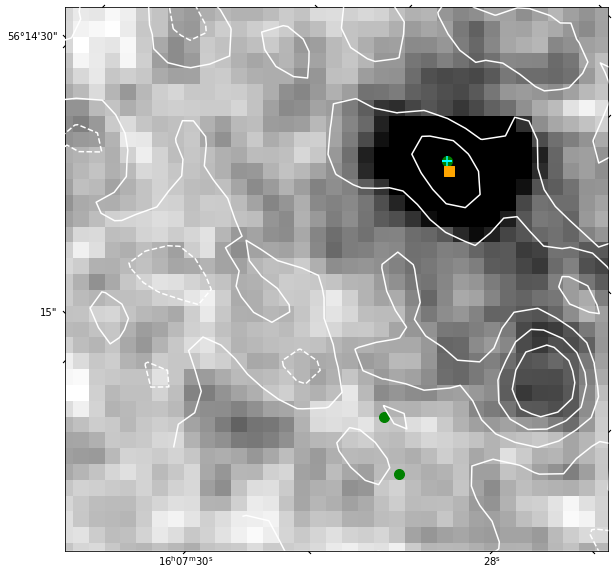

In [205]:
mask = lofar_mips_table['F_MIPS_24']>10**2.5
ra = lofar_mips_table['RA'][mask][3]
dec = lofar_mips_table['Dec'][mask][3]
image_plotting.plot_figure(im24,[mips_prior,lofar_mips_table,lofar_orig],w_24,ra,dec,plot_params,contour_data=[radim_data,radim_wcs])

## Processing PACS output

In [122]:
file_list = glob.glob('data/fir_PACS/*/lofar_xidplus_fir*.fits')
#num_not = np.arange(428,860,1)

lofar_pacs_table = Table.read(file_list[0])
for i,filename in enumerate(file_list[1:]):
    #print(filename)
    if i%50==0:
        print(i)
    
    #print(filename)
    new_table = Table.read(filename,memmap=False)
    if len(new_table)!=20:
        print(filename)
        print('length of table is: {}'.format(len(new_table)))
    lofar_pacs_table = vstack([lofar_pacs_table,new_table])
data_rerun_table = lofar_pacs_table

0
50
100
150
200
250
300
350
data/fir_PACS/xidplus_run_428/lofar_xidplus_fir_428_rerun.fits
length of table is: 9
400


In [123]:
lofar_pacs_table[0]

help_id,RA,Dec,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
ILTJ160624.60+535251.5,241.6028781240088,53.881066302889344,4.852628,8.347854,1.4687959,6.352011,9.049868,2.6306744,0.000520456,0.0005592224,1.5470385e-05,2.7329283e-05,1.0012397,1.0002382,1636.9119,2708.6692,0.0,0.0


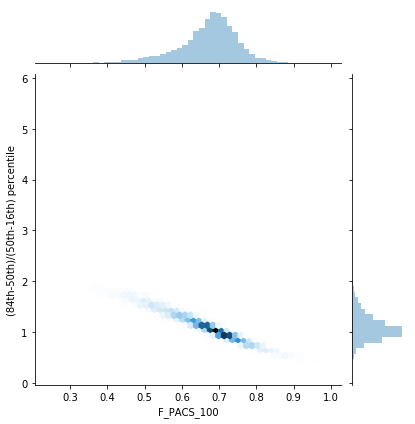

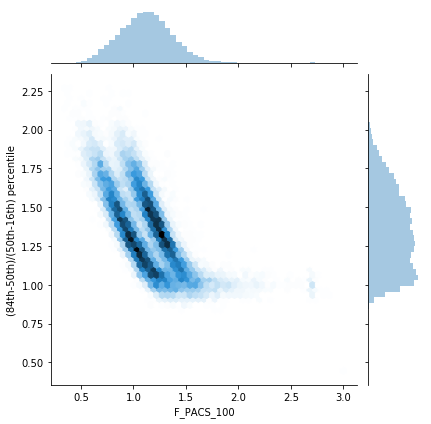

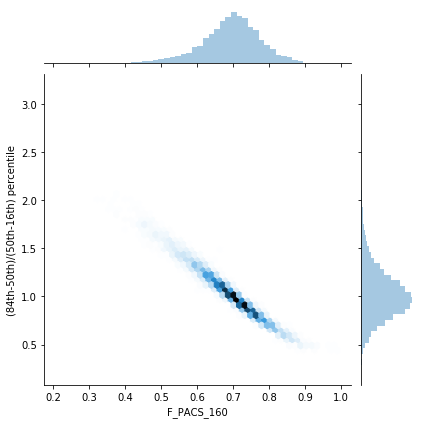

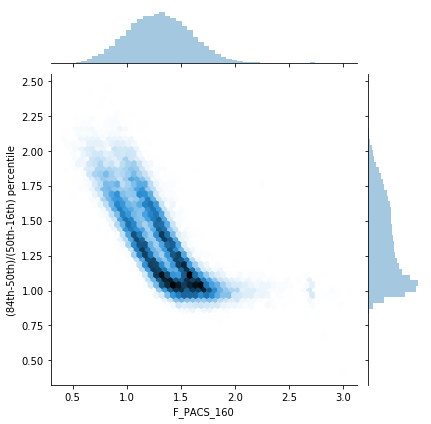

In [125]:
skew=(lofar_pacs_table['FErr_PACS_100_u']-lofar_pacs_table['F_PACS_100'])/(lofar_pacs_table['F_PACS_100']-lofar_pacs_table['FErr_PACS_100_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_pacs_table['F_PACS_100']),y=skew, kind='hex')

skew=(lofar_cat['FErr_PACS_100_u']-lofar_cat['F_PACS_100'])/(lofar_cat['F_PACS_100']-lofar_cat['FErr_PACS_100_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_cat['F_PACS_100']),y=skew, kind='hex')

skew=(lofar_pacs_table['FErr_PACS_160_u']-lofar_pacs_table['F_PACS_160'])/(lofar_pacs_table['F_PACS_160']-lofar_pacs_table['FErr_PACS_160_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_pacs_table['F_PACS_160']),y=skew, kind='hex')

skew=(lofar_cat['FErr_PACS_160_u']-lofar_cat['F_PACS_160'])/(lofar_cat['F_PACS_160']-lofar_cat['FErr_PACS_160_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_cat['F_PACS_160']),y=skew, kind='hex')

In [209]:
lofar_pacs_table.add_column(Column(np.zeros(len(lofar_pacs_table), dtype=bool),name='flag_pacs_100'))
lofar_pacs_table.add_column(Column(np.zeros(len(lofar_pacs_table), dtype=bool),name='flag_pacs_160'))

In [210]:
ind_SERVS_100=(lofar_pacs_table['Pval_res_100']>0.5) | (lofar_pacs_table['F_PACS_100'] < 10)
ind_SERVS_160=(lofar_pacs_table['Pval_res_160']>0.5) | (lofar_pacs_table['F_PACS_160'] < 10)
print(ind_SERVS_100.sum(),ind_SERVS_160.sum(),len(lofar_pacs_table))

lofar_pacs_table['flag_pacs_100'][ind_SERVS_100]=True
lofar_pacs_table['flag_pacs_160'][ind_SERVS_160]=True

8569 8569 8569


In [211]:
lofar_pacs_table[0]

help_id,RA,Dec,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_pacs_100,flag_pacs_160
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool
ILTJ160624.60+535251.5,241.6028781240088,53.881066302889344,4.852628,8.347854,1.4687959,6.352011,9.049868,2.6306744,0.000520456,0.0005592224,1.5470385e-05,2.7329283e-05,1.0012397,1.0002382,1636.9119,2708.6692,0.0,0.0,True,True


In [198]:
imfolder='../../../../../HELP/dmu_products/dmu18/dmu18_ELAIS-N1/data/'

im100fits=imfolder + 'ELAIS-N1-100um-img_wgls.fits'#PACS 100 map
nim100fits=imfolder + 'ELAIS-N1-100um-img_noise.fits'#PACS 100 noise map

hdulist = fits.open(im100fits)
im100phdu=hdulist[0].header
im100hdu=hdulist[0].header
im100=hdulist[0].data
w_100 = wcs.WCS(hdulist[0].header)
pixsize100=3600.0*np.abs(hdulist[0].header['CDELT1']) #pixel size (in arcseconds)
hdulist.close()

hdulist = fits.open(nim100fits)
nim100=hdulist[0].data
hdulist.close()

In [200]:
plot_params = {'marker':['o','+','s','v','X','d'],
              'col':['green','cyan','orange'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False]}

plotting 10 sources
plotting 2 sources
plotting 2 sources


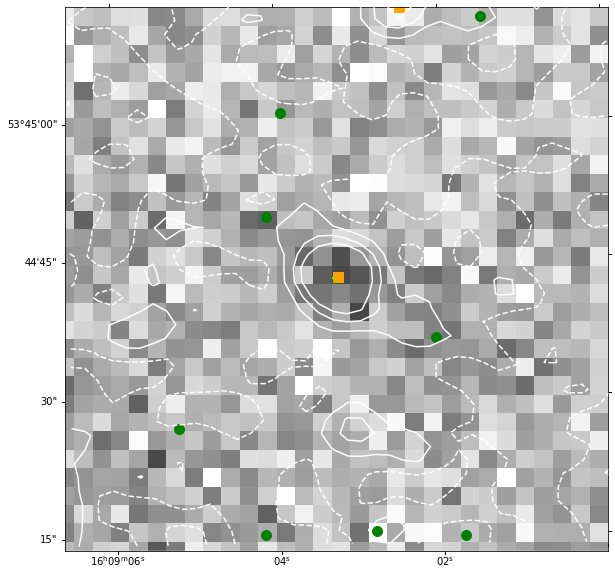

In [201]:
mask = lofar_pacs_table['F_PACS_100']>10**0.9
ra = lofar_pacs_table['RA'][mask][3]
dec = lofar_pacs_table['Dec'][mask][3]
image_plotting.plot_figure(im100,[mips_prior,lofar_mips_table,lofar_orig],w_100,ra,dec,plot_params,contour_data=[radim_data,radim_wcs])

## Processing SPIRE output

In [212]:
file_list = glob.glob('data/fir_v2/*/lofar_xidplus_fir*.fits')
num_not = np.arange(428,860,1)

lofar_spire_table = Table.read(file_list[0])
for i,filename in enumerate(file_list[1:]):
    #print(filename)
    if i%50==0:
        print(i)
    
    run_num = 0
    try:
        run_num = int(filename[24:27])
    except:
        run_num = 0
    #print(run_num)
    if run_num>428:
        continue
    
    #print(filename)
    new_table = Table.read(filename,memmap=False)
    if len(new_table)!=20:
        print(filename)
        print('length of table is: {}'.format(len(new_table)))
    lofar_spire_table = vstack([lofar_spire_table,new_table])
data_rerun_table = lofar_spire_table

0
50
100
150
200
250
300
350
data/fir_v2/xidplus_run_428/lofar_xidplus_fir_428_rerun.fits
length of table is: 8
400


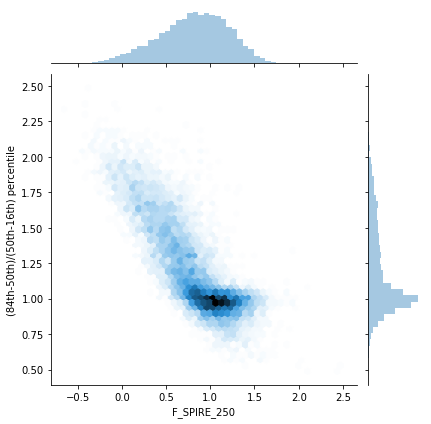

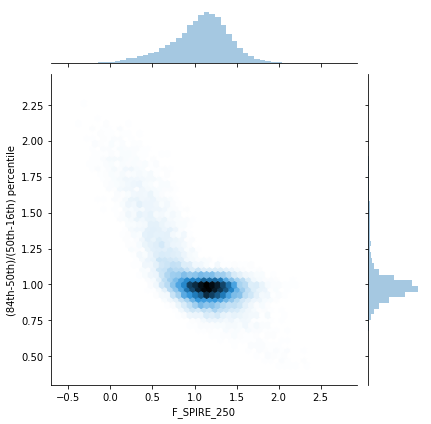

In [213]:
skew=(lofar_spire_table['FErr_SPIRE_250_u']-lofar_spire_table['F_SPIRE_250'])/(lofar_spire_table['F_SPIRE_250']-lofar_spire_table['FErr_SPIRE_250_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_spire_table['F_SPIRE_250']),y=skew, kind='hex')

skew=(lofar_cat['FErr_SPIRE_250_u']-lofar_cat['F_SPIRE_250'])/(lofar_cat['F_SPIRE_250']-lofar_cat['FErr_SPIRE_250_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_cat['F_SPIRE_250']),y=skew, kind='hex')


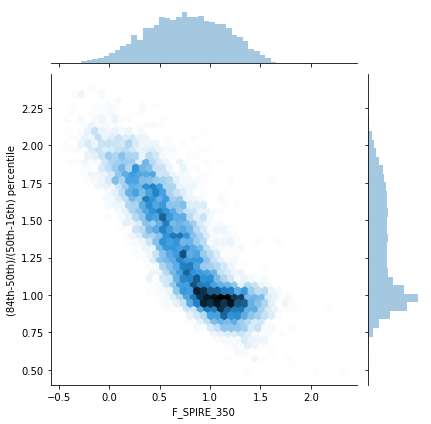

In [214]:
skew=(lofar_spire_table['FErr_SPIRE_350_u']-lofar_spire_table['F_SPIRE_350'])/(lofar_spire_table['F_SPIRE_350']-lofar_spire_table['FErr_SPIRE_350_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_spire_table['F_SPIRE_350']),y=skew, kind='hex')

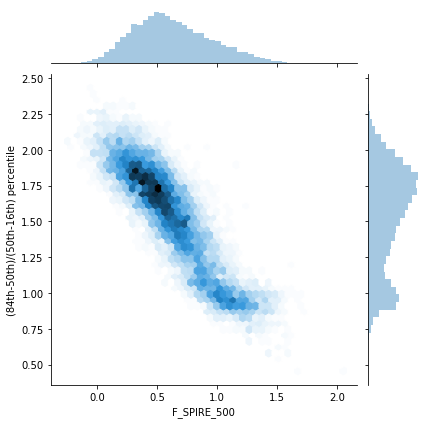

In [215]:
skew=(lofar_spire_table['FErr_SPIRE_500_u']-lofar_spire_table['F_SPIRE_500'])/(lofar_spire_table['F_SPIRE_500']-lofar_spire_table['FErr_SPIRE_500_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(lofar_spire_table['F_SPIRE_500']),y=skew, kind='hex')

In [216]:
lofar_spire_table.add_column(Column(np.zeros(len(lofar_spire_table), dtype=bool),name='flag_spire_250'))
lofar_spire_table.add_column(Column(np.zeros(len(lofar_spire_table), dtype=bool),name='flag_spire_350'))
lofar_spire_table.add_column(Column(np.zeros(len(lofar_spire_table), dtype=bool),name='flag_spire_500'))

In [217]:
ind_SERVS_250=(lofar_spire_table['Pval_res_250']>0.5) | (lofar_spire_table['F_SPIRE_250'] < 10**0.7)
ind_SERVS_350=(lofar_spire_table['Pval_res_350']>0.5) | (lofar_spire_table['F_SPIRE_350'] < 10**0.7)
ind_SERVS_500=(lofar_spire_table['Pval_res_500']>0.5) | (lofar_spire_table['F_SPIRE_500'] < 10**0.9)

print(ind_SERVS_250.sum(),ind_SERVS_350.sum(),ind_SERVS_500.sum(),len(lofar_spire_table))

lofar_spire_table['flag_spire_250'][ind_SERVS_250]=True
lofar_spire_table['flag_spire_350'][ind_SERVS_350]=True
lofar_spire_table['flag_spire_500'][ind_SERVS_500]=True

3331 3935 6931 8568


In [218]:
rerun_col = Column(np.ones(len(lofar_spire_table)),name='XID+_rerun_SPIRE',dtype='bool')
lofar_spire_table.add_column(rerun_col)

In [219]:
lofar_spire_table[0]

HELP_ID,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,XID+_rerun_SPIRE
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,bool
ILTJ160624.60+535251.5,241.6028781240088,53.881066302889344,8.0763855,10.019813,5.8221865,5.396744,8.089904,2.6194236,3.5111027,7.127907,1.0216804,-5.128478,-8.654858,-14.527283,1.7494121,1.9459153,2.4574592,0.999379,1.0013193,0.9995235,1647.4995,2624.2986,1731.2075,0.0,0.002,0.001,False,False,True,True


In [254]:
Table.write(lofar_new_ids,'data/data_release/XID+_lofar_ELAIS-N1.fits',overwrite=True)

### Running checks on the FIR fluxes to see how they compare with the crossmatched fluxes already in the LOFAR catalogue

In [16]:
lofar_cat = Table.read('data/data_release/final_cross_match_catalogue-v0.1.fits')

In [17]:
lofar_cat[0]

Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,FLAG_WORKFLOW,Prefilter,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,FLAG_OVERLAP,Separation,help_id,RA_HELP,DEC_HELP,EBV,Z_SPEC,CLASS_STAR,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,AGN,optAGN,IRAGN,XrayAGN,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,hp_idx_11,hp_depth_cluster
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,bytes27,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bool,bool,bool,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,bytes6,int64,int32
ILTJ155957.58+550052.4,239.98990167026162,55.01456045936245,5.366954914924915e-05,8.08706707123675e-05,0.0003958345213565919,5.4160526835678236e-05,0.0003247963953282784,2.715224507873135e-05,S,0.002071920400992901,0.0016345290335764496,166.30848152559156,0.00019279093100176814,0.00012276320016402095,13.835288085283342,0.0,0.0,0.0,1,0,329.1186755105229,239.98983453474398,55.01474018731156,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,Create initial sources,LR,,7,1,1018637,73464.984,38011.69,239.98983453474398,55.01474018731156,1,1180605,--,7

In [22]:
lofar_xid_join = join(lofar_cat,data_rerun_table,join_type='outer',keys='Source_Name')
lofar_xid_join['XID+_rerun'] = ~lofar_xid_join['XID+_rerun'].mask

In [337]:
lofar_xid_join[:5]

Source_Name,RA_1,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,FLAG_WORKFLOW,Prefilter,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,FLAG_OVERLAP,Separation,help_id,RA_HELP,DEC_HELP,EBV,Z_SPEC,CLASS_STAR,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250_1,FErr_SPIRE_250_u_1,FErr_SPIRE_250_l_1,F_SPIRE_350_1,FErr_SPIRE_350_u_1,FErr_SPIRE_350_l_1,F_SPIRE_500_1,FErr_SPIRE_500_u_1,FErr_SPIRE_500_l_1,Bkg_SPIRE_250_1,Bkg_SPIRE_350_1,Bkg_SPIRE_500_1,Sig_conf_SPIRE_250_1,Sig_conf_SPIRE_350_1,Sig_conf_SPIRE_500_1,Rhat_SPIRE_250_1,Rhat_SPIRE_350_1,Rhat_SPIRE_500_1,n_eff_SPIRE_250_1,n_eff_SPIRE_500_1,n_eff_SPIRE_350_1,Pval_res_250_1,Pval_res_350_1,Pval_res_500_1,flag_spire_250,flag_spire_350,flag_spire_500,AGN,optAGN,IRAGN,XrayAGN,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,hp_idx_11,hp_depth_cluster,RA_2,Dec,F_SPIRE_250_2,FErr_SPIRE_250_u_2,FErr_SPIRE_250_l_2,F_SPIRE_350_2,FErr_SPIRE_350_u_2,FErr_SPIRE_350_l_2,F_SPIRE_500_2,FErr_SPIRE_500_u_2,FErr_SPIRE_500_l_2,Bkg_SPIRE_250_2,Bkg_SPIRE_350_2,Bkg_SPIRE_500_2,Sig_conf_SPIRE_250_2,Sig_conf_SPIRE_350_2,Sig_conf_SPIRE_500_2,Rhat_SPIRE_250_2,Rhat_SPIRE_350_2,Rhat_SPIRE_500_2,n_eff_SPIRE_250_2,n_eff_SPIRE_500_2,n_eff_SPIRE_350_2,Pval_res_250_2,Pval_res_350_2,Pval_res_500_2,XID+_rerun
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,
bytes27,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,bytes27,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bool,bool,bool,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float

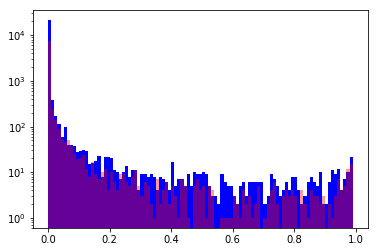

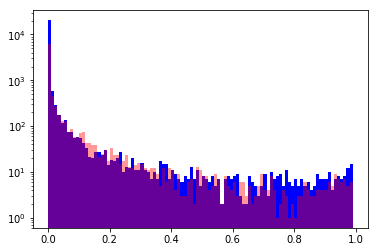

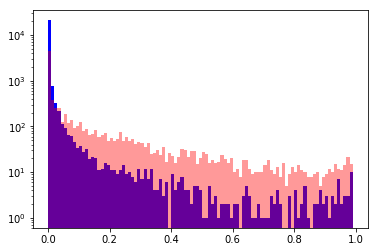

In [73]:
bins = np.arange(0,1,0.01)
dat = lofar_cat['Pval_res_250']
plt.hist(dat,bins=bins,log=True,color='blue')

dat = data_rerun_table['Pval_res_250']
plt.hist(dat,bins=bins,log=True,color='red',alpha=0.4)

plt.show()

dat = lofar_cat['Pval_res_350']
plt.hist(dat,bins=bins,log=True,color='blue')

dat = data_rerun_table['Pval_res_350']
plt.hist(dat,bins=bins,log=True,color='red',alpha=0.4)

plt.show()

dat = lofar_cat['Pval_res_500']
plt.hist(dat,bins=bins,log=True,color='blue')

dat = data_rerun_table['Pval_res_500']
plt.hist(dat,bins=bins,log=True,color='red',alpha=0.4)

plt.show()

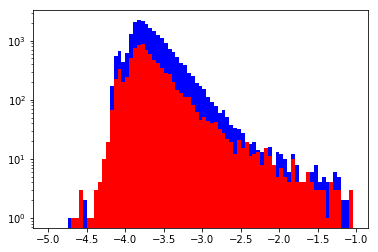

In [88]:
mask = ~np.isnan(lofar_cat['F_SPIRE_250'])
bins = np.arange(-5,-1,0.05)
dat = np.log10(lofar_cat['Peak_flux'][mask])
plt.hist(dat,bins=bins,log=True,color='blue')

dat = np.log10(lofar_cat['Peak_flux'][~mask])
plt.hist(dat,bins=bins,log=True,color='red')
plt.show()

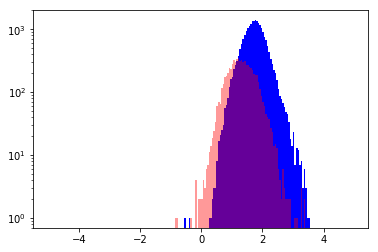

In [92]:
mask = ~np.isnan(lofar_cat['F_SPIRE_250'])
bins = np.arange(-5,5,0.05)
dat = np.log10(lofar_cat['ch1_swire_flux'][mask])
plt.hist(dat,bins=bins,log=True,color='blue')

dat = np.log10(lofar_cat['ch1_swire_flux'][~mask])
plt.hist(dat,bins=bins,log=True,color='red',alpha=0.4)
plt.show()

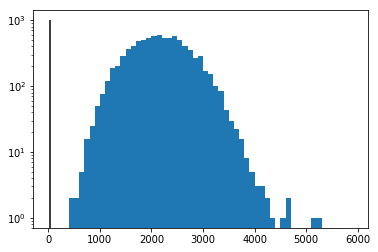

In [98]:
bins = np.arange(0,6000,100)
dat = data_rerun_table['n_eff_SPIRE_250']
plt.hist(dat,bins=bins,log=True)
plt.vlines(40,0,1000)
plt.show()

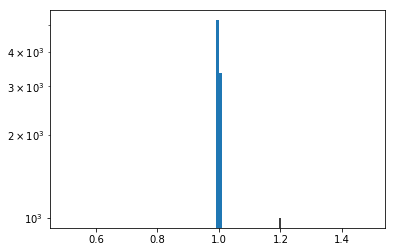

In [101]:
bins = np.arange(0.5,1.5,0.01)
dat = data_rerun_table['Rhat_SPIRE_250']
plt.hist(dat,bins=bins,log=True)
plt.vlines(1.2,0,1000)
plt.show()

In [328]:
len(lofar_xid_join)

31748

23179
8569


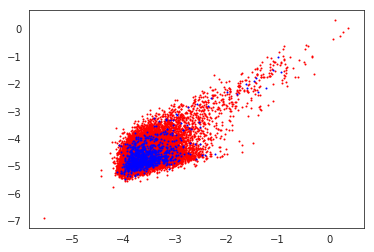

In [342]:
mask = lofar_xid_join['XID+_rerun']
bins = np.arange(0,5,0.1)

#plt.hist(dat,bins=bins,log=True,color='blue')
dist = cosmo.luminosity_distance(dat).to(u.m).value
rad = np.log10(lofar_xid_join['Total_flux'][~mask])
fir = np.log10(lofar_xid_join['F_SPIRE_250_1'][~mask])
y = rad-fir
print(len(y))
plt.scatter(rad,y,s=1,c='red')


#plt.hist(dat,bins=bins,log=True,color='red',alpha=0.4)
rad = np.log10(lofar_xid_join['Total_flux'][mask])
fir = np.log10(lofar_xid_join['F_SPIRE_250_1'][mask])
y = rad-fir
print(len(y))
plt.scatter(rad,y,s=1,c='blue')
plt.show()

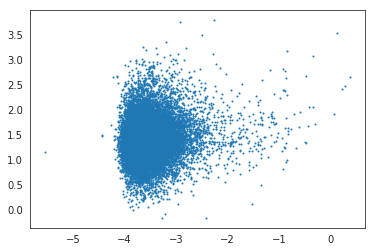

In [349]:
mask = ~lofar_xid_join['XID+_rerun']
x = np.log10(lofar_xid_join['Total_flux'][mask])
y = np.log10(lofar_xid_join['F_MIPS_24'][mask]/lofar_xid_join['F_SPIRE_250_1'][mask])
plt.scatter(x,y,s=1)
plt.show()

26328
6500


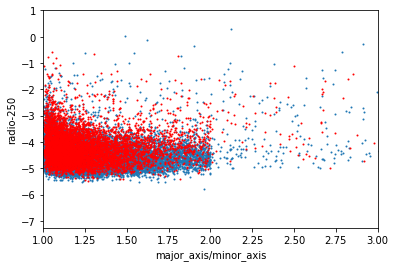

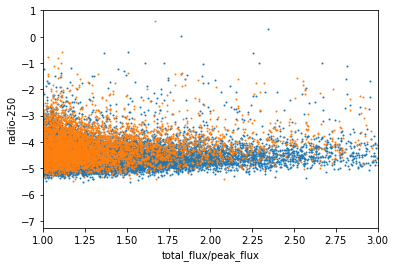

In [74]:
mask = ~lofar_xid_join['XID+_rerun']
x = lofar_xid_join['Maj'][mask]/lofar_xid_join['Min'][mask]
print(len(x))
y = np.log10(lofar_xid_join['Total_flux'][mask]/lofar_xid_join['F_SPIRE_250_1'][mask])
plt.scatter(x,y,s=1)

mask = lofar_xid_join['XID+_rerun']
x = lofar_xid_join['Maj'][mask]/lofar_xid_join['Min'][mask]
print(len(x))
y = np.log10(lofar_xid_join['Total_flux'][mask]/lofar_xid_join['F_SPIRE_250_2'][mask])
plt.scatter(x,y,s=1,c='red')

plt.xlim(1,3)
plt.xlabel('major_axis/minor_axis')
plt.ylabel('radio-250')
plt.show()

mask = ~lofar_xid_join['XID+_rerun']
x = lofar_xid_join['Total_flux'][mask]/lofar_xid_join['Peak_flux'][mask]
y = np.log10(lofar_xid_join['Total_flux'][mask]/lofar_xid_join['F_SPIRE_250_1'][mask])
plt.scatter(x,y,s=1)

mask = lofar_xid_join['XID+_rerun']
x = lofar_xid_join['Total_flux'][mask]/lofar_xid_join['Peak_flux'][mask]
y = np.log10(lofar_xid_join['Total_flux'][mask]/lofar_xid_join['F_SPIRE_250_2'][mask])
plt.scatter(x,y,s=1)

plt.xlim(1,3)
plt.xlabel('total_flux/peak_flux')
plt.ylabel('radio-250')
plt.show()

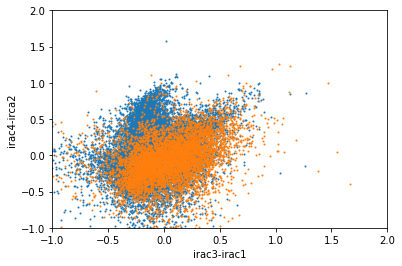

In [75]:
mask = ~np.isnan(lofar_cat['F_SPIRE_250']) #& (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
c1 = np.log10(lofar_cat['ch3_swire_flux'][mask]/lofar_cat['ch1_swire_flux'][mask])
c2 = np.log10(lofar_cat['ch4_swire_flux'][mask]/lofar_cat['ch2_swire_flux'][mask])
plt.scatter(c1,c2,s=1)

mask = np.isnan(lofar_cat['F_SPIRE_250']) #& (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
c1 = np.log10(lofar_cat['ch3_swire_flux'][mask]/lofar_cat['ch1_swire_flux'][mask])
c2 = np.log10(lofar_cat['ch4_swire_flux'][mask]/lofar_cat['ch2_swire_flux'][mask])
z_col = lofar_cat['z1_median'][mask]
z_bins = np.arange(0,4,0.5)
z_binned = np.digitize(z_col,z_bins)
#plt.scatter(c1[0],c2[0],s=100,c='red')
plt.scatter(c1,c2,s=1)
#plt.scatter(c1[0],c2[0],s=10,c='red')
#plt.scatter(c1[0],c2[0],s=1,c=z_binned[0])


plt.xlim(-1,2)
plt.ylim(-1,2)
plt.xlabel('irac3-irac1')
plt.ylabel('irac4-irca2')
#plt.title('{} < z < {}'.format(z_bins[n],z_bins[n+1]))
plt.show()

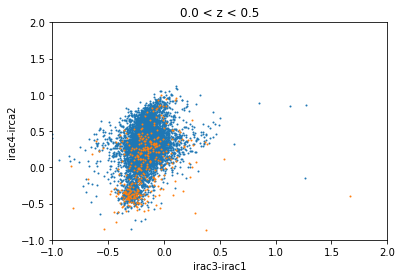

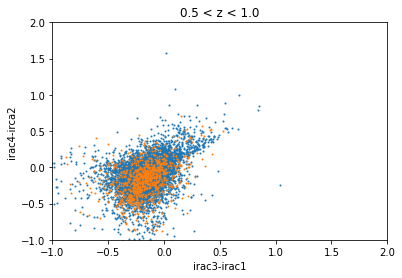

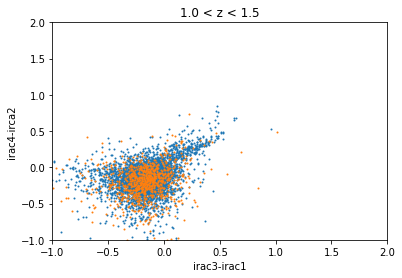

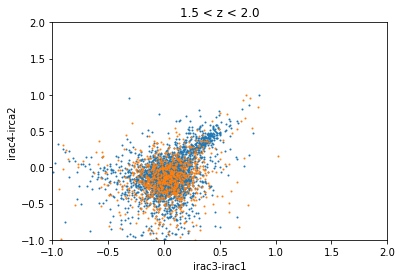

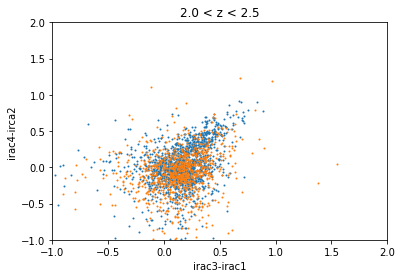

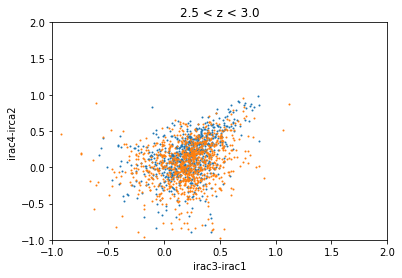

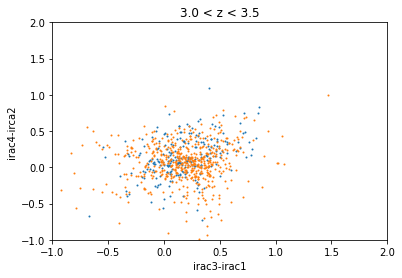

In [76]:
z_bins = np.arange(0,4,0.5)
dist = cosmo.luminosity_distance(lofar_cat['z1_median']).to(u.m).value
ch1_lum = lofar_cat['ch1_swire_flux']*4*np.pi*dist**2
ch2_lum = lofar_cat['ch2_swire_flux']*4*np.pi*dist**2
ch3_lum = lofar_cat['ch3_swire_flux']*4*np.pi*dist**2
ch4_lum = lofar_cat['ch4_swire_flux']*4*np.pi*dist**2
for n in range(len(z_bins)-1):
    mask = ~np.isnan(lofar_cat['F_SPIRE_250']) & (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
    c1 = np.log10(lofar_cat['ch3_swire_flux'][mask]/lofar_cat['ch1_swire_flux'][mask])
    c2 = np.log10(lofar_cat['ch4_swire_flux'][mask]/lofar_cat['ch2_swire_flux'][mask])
    plt.scatter(c1,c2,s=1)

    mask = np.isnan(lofar_cat['F_SPIRE_250']) & (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
    c1 = np.log10(lofar_cat['ch3_swire_flux'][mask]/lofar_cat['ch1_swire_flux'][mask])
    c2 = np.log10(lofar_cat['ch4_swire_flux'][mask]/lofar_cat['ch2_swire_flux'][mask])
    z_col = lofar_cat['z1_median'][mask]
    z_bins = np.arange(0,4,0.5)
    z_binned = np.digitize(z_col,z_bins)
#plt.scatter(c1[0],c2[0],s=100,c='red')
    plt.scatter(c1,c2,s=1)
#plt.scatter(c1[0],c2[0],s=10,c='red')
#plt.scatter(c1[0],c2[0],s=1,c=z_binned[0])


    plt.xlim(-1,2)
    plt.ylim(-1,2)
    plt.xlabel('irac3-irac1')
    plt.ylabel('irac4-irca2')
    plt.title('{} < z < {}'.format(z_bins[n],z_bins[n+1]))
    plt.show()

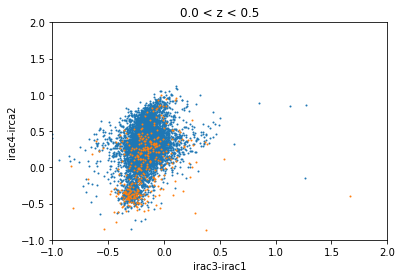

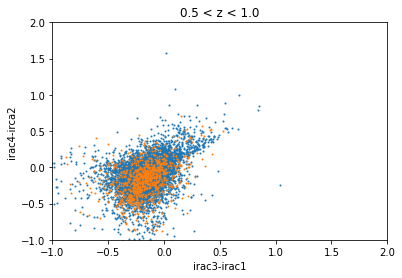

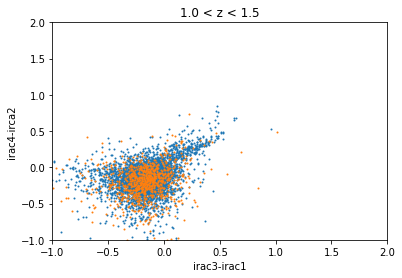

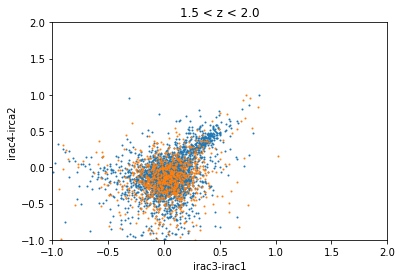

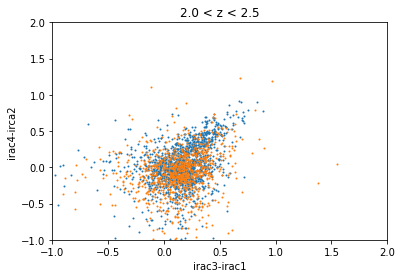

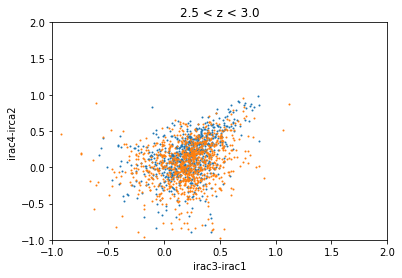

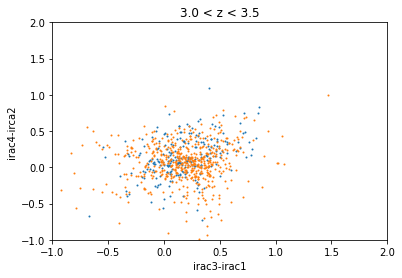

In [31]:
z_bins = np.arange(0,4,0.5)
dist = cosmo.luminosity_distance(lofar_cat['z1_median']).to(u.m).value
ch1_lum = lofar_cat['ch1_swire_flux']*4*np.pi*dist**2
ch2_lum = lofar_cat['ch2_swire_flux']*4*np.pi*dist**2
ch3_lum = lofar_cat['ch3_swire_flux']*4*np.pi*dist**2
ch4_lum = lofar_cat['ch4_swire_flux']*4*np.pi*dist**2
for n in range(len(z_bins)-1):
    mask = ~np.isnan(lofar_cat['F_SPIRE_250']) & (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
    c1 = np.log10(ch3_lum[mask]/ch1_lum[mask])
    c2 = np.log10(ch4_lum[mask]/ch2_lum[mask])
    plt.scatter(c1,c2,s=1)

    mask = np.isnan(lofar_cat['F_SPIRE_250']) & (lofar_cat['z1_median']>z_bins[n]) & (lofar_cat['z1_median']<z_bins[n+1])
    c1 = np.log10(ch3_lum[mask]/ch1_lum[mask])
    c2 = np.log10(ch4_lum[mask]/ch2_lum[mask])
    z_col = lofar_cat['z1_median'][mask]
    z_bins = np.arange(0,4,0.5)
    z_binned = np.digitize(z_col,z_bins)
#plt.scatter(c1[0],c2[0],s=100,c='red')
    plt.scatter(c1,c2,s=1)
#plt.scatter(c1[0],c2[0],s=10,c='red')
#plt.scatter(c1[0],c2[0],s=1,c=z_binned[0])


    plt.xlim(-1,2)
    plt.ylim(-1,2)
    plt.xlabel('irac3-irac1')
    plt.ylabel('irac4-irca2')
    plt.title('{} < z < {}'.format(z_bins[n],z_bins[n+1]))
    plt.show()